# Lab 3 - Part 1: Classification and Grid Search (33 marks)
### Due Date: Monday, March 13 at 12pm

Author: *Steven Duong (30022492)*

In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

The purpose of this portion of the assignment is to practice following the grid-search workflow: 
- Split data into training and test set
- Use the training portion to find the best model using grid search and cross-validation
- Retrain the best model
- Evaluate the retrained model on the test set

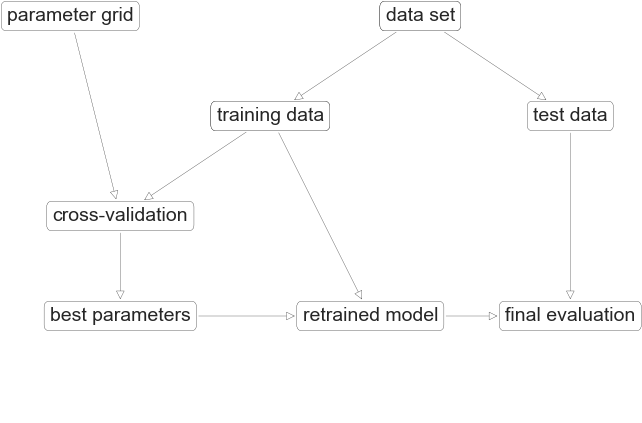

In [69]:
import mglearn
mglearn.plots.plot_grid_search_overview()

## 0. Function definitions (2 marks)

In [70]:
from sklearn.model_selection import cross_validate


def get_classifier_cv_score(model, X, y, scoring='accuracy', cv=7):
    '''Calculate train and validation scores of classifier (model) using cross-validation
        
        
        model (sklearn classifier): Classifier to train and evaluate
        X (numpy.array or pandas.DataFrame): Feature matrix
        y (numpy.array or pandas.Series): Target vector
        scoring (str): a scoring string accepted by sklearn.metrics.cross_validate()
        cv (int): number of cross-validation folds see sklearn.metrics.cross_validate()
        
        returns: mean training score, mean validation score
    
    '''
    
    score = cross_validate(estimator=model, X=X, y=y, cv=cv, scoring=scoring, return_train_score=True)
    return (score['train_score'].mean(), score['test_score'].mean())
    

In [71]:
# DO NOT NEED TO ADD ANYTHING TO THIS FUNCTION
def print_grid_search_result(grid_search):
    '''Prints summary of best model from GridSearchCV object.
    
        For the best model of the grid search, print:
        - parameters 
        - cross-validation training score
        - cross-validation validation score 
        
        scores are printed with 3 decimal places
    
        grid_search (sklearn GridSearchCV): Fitted GridSearchCV object
        
        returns: None
        
    '''
    
    print(grid_search.best_params_)
    print("training score= {:.3f}; validation score={:.3f}".format(grid_search.cv_results_['mean_train_score'][grid_search.best_index_],
                                                                  grid_search.cv_results_['mean_test_score'][grid_search.best_index_]))

In [72]:
# DO NOT NEED TO ADD ANYTHING TO THIS FUNCTION
import mglearn

def plot_grid_search_results(grid_search):
    '''For grids with 2 hyperparameters, create a heatmap plot of test scores
        
        grid_search (sklearn GridSearchCV): Fitted GridSearchCV object
        
        uses mglearn.tools.heatmap() for plotting
    
    '''
    results = pd.DataFrame(grid_search.cv_results_)

    params = sorted(grid_search.param_grid.keys())
    
    assert len(params) == 2, "We can only plot two parameters."
    
    # second dimension in reshape are rows, needs to be the fast changing parameter
    scores = np.array(results.mean_test_score).reshape(len(grid_search.param_grid[params[0]]),
                                                      len(grid_search.param_grid[params[1]]))

    # plot the mean cross-validation scores
    # x-axis needs to be the fast changing parameter
    mglearn.tools.heatmap(scores, 
                          xlabel=params[1], 
                          xticklabels=grid_search.param_grid[params[1]], 
                          ylabel=params[0], 
                          yticklabels=grid_search.param_grid[params[0]],
                          cmap="viridis", fmt="%0.3f")

In [73]:
# DO NOT NEED TO ADD ANYTHING TO THIS FUNCTION
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_actual, y_pred, labels, title):
    '''Creates a heatmap plot of the confusion matrix.
    
        y_actual (pandas.DataSeries or numpy.Array): Ground truth label vector
        y_pred (pandas.DataSeries or numpy.Array): Predicted label vector
        labels (list(str)): Class names used for plotting (ticklabels)
        title (str): Plot title
        
        uses sklearn.metrics.confusion_matrix
        
    '''
    
    mat = confusion_matrix(y_actual, y_pred)

    sns.heatmap(mat, 
                xticklabels=labels,  
                yticklabels=labels, 
                square=True, annot=True, cbar=False, 
                fmt='d')
    plt.xlabel('predicted value')
    plt.ylabel('true value')
    plt.title(title)

## 1. Load data (2 marks)
yellowbrick mushroom  
https://www.scikit-yb.org/en/latest/api/datasets/mushroom.html




### 1.1 Prepare the feature matrix and target vector

Using the yellowbrick `load_mushroom()` function, load the mushroom data set into feature matrix `X` and target vector `y`

Print shape and type of `X`, `y`

In [74]:
from yellowbrick.datasets import load_mushroom
X, y = load_mushroom()

print(f"The shape of X is: {X.shape}. The type of X is: {type(X)}")
print(f"The shape of y is: {y.shape}. The type of y is: {type(y)}")

The shape of X is: (8123, 3). The type of X is: <class 'pandas.core.frame.DataFrame'>
The shape of y is: (8123,). The type of y is: <class 'pandas.core.series.Series'>


## 2. Preprocessing (4 marks)
In this dataset, all features are discrete and nominal and need to be encoded. We will use a `OneHotEncoder`

The target vector is discrete and nominal as well and contains string labels. While sklearn is OK using string labels in target vectors, you will use a `LabelEncoder` explicitly to convert strings to integers and keep the encoder to translate between the two representations

### 2.1 Onehot encoding of features
Use `OneHotEncoder` to convert `X` into one-hot-encoded features stored in a variable `X_enc`. Use `sparse=False`. Print shape of `X_enc`

In [75]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse=False)
X_enc = encoder.fit(X).transform(X)

print(X_enc.shape)

(8123, 20)


### 2.2 Label encode target vector 
Use `LabelEncoder` to encode the target vector `y`, saved in a variable `y_enc`

Print the resulting target vector `y_enc` and print the class names available in the `classes_` attribute of the `LabelEncoder` object

In [76]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_enc = label_encoder.fit(y).transform(y)

print(f"Encoded Target Vector: {y_enc}")
print(f"Class Names: {label_encoder.classes_}")

Encoded Target Vector: [0 0 1 ... 0 1 0]
Class Names: ['edible' 'poisonous']


## 3. Create training and test sets (1 mark)
Using scikit-learn `train_test_split()` with parameters `random_state=37`, `test_size=0.2`, split `X_enc` and `y_enc` into training and test sets

In [77]:
from sklearn.model_selection import train_test_split

# splitting the data into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(X_enc, y_enc, random_state=37, test_size=0.2)

## 4. Compare models using cross-validation (4 marks)
Create a list containing `LogisticRegression()`, 
          `SVC()`,
          `BernoulliNB()`,
        `RandomForestClassifier(random_state=55)`, 
         `GradientBoostingClassifier(random_state=56)` objects.

Iterate this list, then:
- Compute the **f1 score** using `get_classifier_cv_score()` with the 7-fold cross-validation defined above with `X_train` and `y_train` as arguments
- Print the models' training and validation scores with **3 decimal places**

In [78]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import f1_score
import numpy as np

# list of models
models = [LogisticRegression(), SVC(), BernoulliNB(), RandomForestClassifier(random_state=55), 
          GradientBoostingClassifier(random_state=56)]

# list to store the results of each model
results = []

# iterating through the list
for model in models:
    train_score, val_score = get_classifier_cv_score(model, X_train, y_train, scoring='f1')
    results.append({'Model': model.__class__.__name__, 'Train Score': train_score, 'Validation Score': val_score})

# creating the dataframe
df = pd.DataFrame(results)
df = df.round(decimals=3) # sets scores to 3 decimal places
print(df)


                        Model  Train Score  Validation Score
0          LogisticRegression        0.663             0.664
1                         SVC        0.691             0.678
2                 BernoulliNB        0.614             0.613
3      RandomForestClassifier        0.692             0.678
4  GradientBoostingClassifier        0.702             0.692


## 5. Hyperparameter tuning using grid search (8 marks)

The inital cross-validation above gives us an idea of how algorithms perform using their default hyperparameters

Next, we will try and improve one model by tuning its hyperparameters using grid search

### 5.1 Grid search for RandomForestClassifier 

Perform grid search using `GridSearchCV` for the `RandomForestClassifier(n_estimators=300, random_state=55)`:

- Set the number of trees `n_estimators=300` for all evaluations
- Grid search using 7-fold cross-validation and `f1` as the scoring function 
- Note that there is a `n_jobs` parameter to run search in parallel. Setting it to the number of CPU cores  or -1 works well

Use the following hyperparameters and values:
- `'max_depth': [3, 5, 8]`
- `'max_features': [0.3, 0.5, 0.7, 0.9]`

From sklearn help:
> - max_depth: The maximum depth of the tree
> - max_features: If float, then max_features is a fraction and max(1, int(max_features * n_features)) features are considered at each split


Use the `print_grid_search_result()` and `plot_grid_search_result()` functions defined above to show the results

In [79]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import multiprocessing

# setup grid search for RandomForestClassifier(random_state=55)
param_grid = {
    'max_depth': [3, 5, 8],
    'max_features': [0.3, 0.5, 0.7, 0.9]
}

rf = RandomForestClassifier(n_estimators=300, random_state=55)

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='f1', cv=7, n_jobs=-1, return_train_score=True)


In [80]:
# perform the grid search by calling fit() with X_train and y_train
grid_search.fit(X_train, y_train)

GridSearchCV(cv=7,
             estimator=RandomForestClassifier(n_estimators=300,
                                              random_state=55),
             n_jobs=-1,
             param_grid={'max_depth': [3, 5, 8],
                         'max_features': [0.3, 0.5, 0.7, 0.9]},
             return_train_score=True, scoring='f1')

In [81]:
# call print_grid_search_result() to print the results
print_grid_search_result(grid_search)

{'max_depth': 5, 'max_features': 0.7}
training score= 0.719; validation score=0.716


### *Question 1:* What is the validation score of the best model? Which models in Section 4 does it outperform?

The validation score of the best model is 0.716, with max_depth=5 and max_features=0.7. Overall, this model, when tuned for hyperparameters, outperforms all the models tested in section 4.

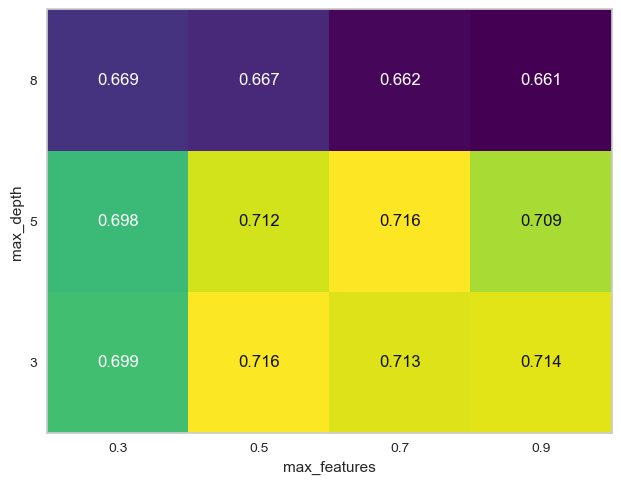

In [82]:
# call plot_grid_search_results() to plot validation metrics for all hyperparameter combinations
plot_grid_search_results(grid_search)

### *Question 2:* Where in the hyperparameter ranges does the maximum occur? Would you need to adjust the hyperparameter ranges to find a better model?

According to the heat map generated above, the maximum occurs when the hyperparameter range is: max_depth=5, max_features=0.7, and max_depth=3, max_features=0.5. Which is in the center of the model.

According to these results, hyperparameter ranges used in the grid search are reasonable and do not need to be adjusted in order to find a better model, since an increase in range would lead to overfitting and a decrease in range would lead to underfitting.


## 6. Re-train best model (2 marks)
Re-train the best `RandomForestClassifier()` from the grid search above on the training dataset `X_train` and `y_train`

In [83]:
# re-training the random forest model with the best parameters

best_rf = grid_search.best_estimator_
best_rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, max_features=0.7, n_estimators=300,
                       random_state=55)

## 7. Evaluate using test data (4 marks)

Using the retrained model and the test dataset `X_test` and `y_test`:
- plot the confusion matrix using the `plot_confusion_matrix()` function defined above
- print the classification report

Make sure the plot has class labels and a title

### 7.1 Confusion matrix and classification report

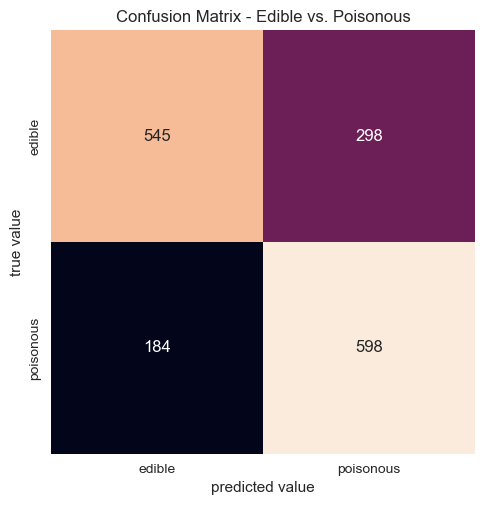

In [84]:
from sklearn.metrics import classification_report

y_pred = best_rf.predict(X_test)

# calling plot_confusion_matrix(), and using LabelEncoder classes_ to get the labels
plot_confusion_matrix(y_test, y_pred, label_encoder.classes_, title='Confusion Matrix - Edible vs. Poisonous')


### 7.2 Classification report

In [85]:
# printing classification report using default threshold
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.65      0.69       843
           1       0.67      0.76      0.71       782

    accuracy                           0.70      1625
   macro avg       0.71      0.71      0.70      1625
weighted avg       0.71      0.70      0.70      1625



### *Question 3:* What are the precision, recall and accuracy for the positive class on the test set?

#### Positive Class Metrics
- Precision = 0.67
- Recall = 0.76
- Accuracy = 0.70


### *Question 4:* How many false negatives and false positives does the model produce on the test set?

#### Binary Classification Metrics

- Number of false positives (FP) = 298
- Number of false negatives (FN) = 184


## 8. Conclusion (4 marks)

In the conclusion, comment on the following items and use data to support your findings:
1. In the classification of edible vs poisonous mushrooms, what do false positive and false negative predictions imply and what are the consequences of making these mistakes?
2. In the classification of edible vs poisonous mushrooms, why is high recall desired?
3. Reflect on the usefulness of this model if it would be put into production and propose ways to improve the model and/or application
  

1. **False positive:** the model predicts that a mushroom is poisonous when it is actually edible. This mistake may lead people to avoid safe mushrooms, which reduces the variety and nutritional quality of their diet. It can also lead to unnecessary waste and economic losses for mushroom growers and sellers.
  
    **False negative:** the model predicts that a mushroom is edible when it is actually poisonous. This mistake is more dangerous as it may lead people to consume toxic mushrooms, which can cause illness, organ damage, or even death.
  
   
2. In the classification of edible vs poisonous mushrooms, high recall is desired because it minimizes the risk of false negative predictions. In other words, a high recall means that the model correctly identifies most of the poisonous mushrooms, reducing the chances of people consuming toxic mushrooms.
  
  
3. The usefulness of this model in production depends on its accuracy, reliability, and usability. Some ways to improve the model and/or application are:

    Increase the size and diversity of the dataset used to train the model, to capture more variations and nuances of edible and poisonous mushrooms.
Incorporate more features and information about the mushrooms, such as their morphology, habitat, and chemical composition, to enhance the model's predictive power.
Evaluate and fine-tune the model's hyperparameters, such as the learning rate, regularization, and activation functions, to optimize its performance on the validation set.
Implement an explainable AI system that can provide insights and justifications for the model's predictions, to increase the transparency and trustworthiness of the application.
Provide user-friendly interfaces and instructions for the users, such as visual aids, warnings, and recommendations, to facilitate their decision-making and minimize the risk of errors or misunderstandings.

## 9. Reflection (2 marks)
Include a sentence or two about:
- what you liked or disliked,
- found interesting, confusing, challenging, motivating while working on this assignment 

Can include thoughts from Lab 3-2 as well

As I worked on this assignment, I found several aspects of it to be enjoyable and motivating. One thing that I really liked was the opportunity to work with a new dataset, in this case the yellowbricks mushroom dataset. It was interesting to explore the different variables and gain insights into the characteristics of the data. Additionally, I found the topic of hyperparameter tuning with grid search to be both challenging and motivating. It required me to think critically about the best combinations of parameters to optimize the model's performance in order to determine which mushrooms were poisonous and edible.